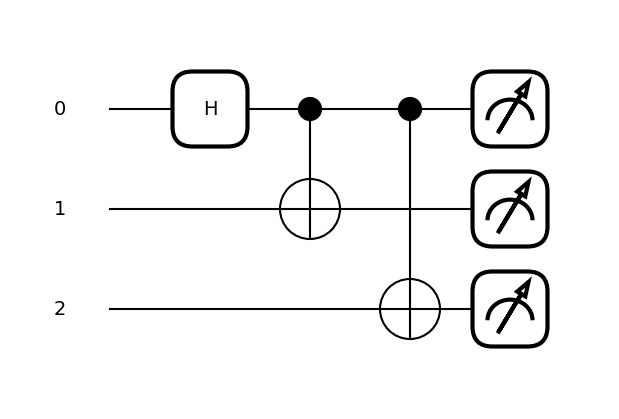

Probabilities of states after no error:
State |000⟩: 0.5000
State |001⟩: 0.0000
State |010⟩: 0.0000
State |011⟩: 0.0000
State |100⟩: 0.0000
State |101⟩: 0.0000
State |110⟩: 0.0000
State |111⟩: 0.5000




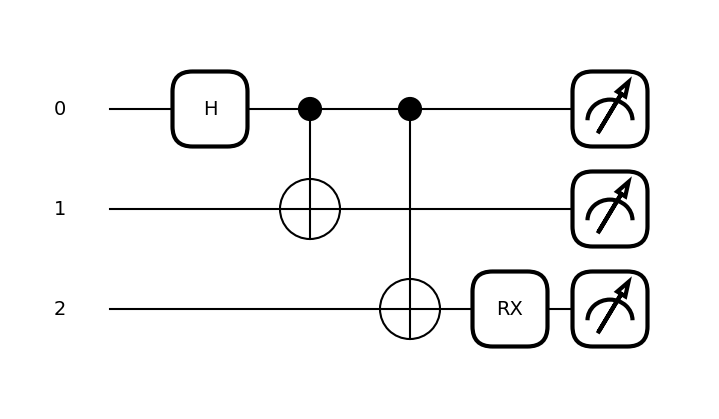

Probabilities of states after weak error:
State |000⟩: 0.3750
State |001⟩: 0.1250
State |010⟩: 0.0000
State |011⟩: 0.0000
State |100⟩: 0.0000
State |101⟩: 0.0000
State |110⟩: 0.1250
State |111⟩: 0.3750


Expectation value of Z1Z2: 0.5000
Expectation value of Z1Z3: 0.5000


In [7]:
# Importing necessary libraries
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the number of qubits
n_qubits = 3

# Initialize a device
dev = qml.device('default.qubit', wires=n_qubits)

# Define the initial state preparation function
def initial_state():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])

# Define the weak error function
def apply_weak_error():
    # Randomly select one of the three qubits
    qubit_to_flip = random.randint(0, 2)
    # Apply a small rotation around the X axis to simulate a weak bit-flip error
    epsilon = np.pi /3
    qml.RX(epsilon, wires=qubit_to_flip)

def plot_circuit_and_probs(circuit, *args, description=""):
    # Execute the circuit to obtain the probabilities
    probs = circuit(*args)
    # Calculate the squared magnitude of each probability amplitude
    squared_probs = np.abs(probs)**2
    # Draw the circuit
    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(*args)
    plt.show()
    # Print the probabilities
    print(f"Probabilities of states after {description}:")
    for i, p in enumerate(squared_probs):
        print(f"State |{i:03b}⟩: {p:.4f}")
    print("\n")

def apply_Z1_Z2():
    qml.PauliZ(wires=0)
    qml.PauliZ(wires=1)

def apply_Z1_Z3():
    qml.PauliZ(wires=0)
    qml.PauliZ(wires=2)

# Define the quantum node
@qml.qnode(dev)
def circuit1():
    initial_state()
    return qml.state()

# Define the quantum node
@qml.qnode(dev)
def circuit2():
    initial_state()
    apply_weak_error()
    return qml.state()

# Define the quantum node for measuring the expectation value of Z1Z2 after the weak error
@qml.qnode(dev)
def circuit_Z1Z2():
    initial_state()
    apply_weak_error()
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Define the quantum node for measuring the expectation value of Z1Z3 after the weak error
@qml.qnode(dev)
def circuit_Z1Z3():
    initial_state()
    apply_weak_error()
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(2))

# Plot the circuit and the probabilities
plot_circuit_and_probs(circuit1, description="no error")

# Plot the circuit and the probabilities
plot_circuit_and_probs(circuit2, description="weak error")


# Measure Z1Z2 and print the resulting probabilities
eig_Z1Z2 = circuit_Z1Z2()
eig_Z1Z3 = circuit_Z1Z3()

# Print the measured expectation value
print(f"Expectation value of Z1Z2: {eig_Z1Z2:.4f}")
print(f"Expectation value of Z1Z3: {eig_Z1Z3:.4f}")